In [53]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import cvxpy as cp
from mpl_toolkits.mplot3d import Axes3D
from copy import copy, deepcopy
from scipy.optimize import linprog

In [54]:
#Lire les images et les mettre au format BGR
image1 = cv2.imread('./painting-1.jpg')
image2 = cv2.imread('./painting-2.jpg')

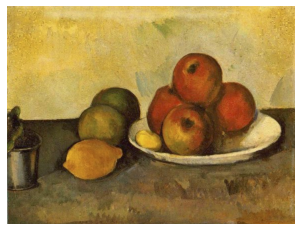

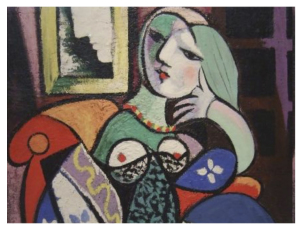

In [55]:
#Transformer des images au format RGB et les afficher
pomme_img = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
plt.imshow(pomme_img)
plt.axis("off")
plt.show()
femme_img = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
plt.imshow(femme_img)
plt.axis("off")
plt.show()

In [56]:
#Voir la taille des images
print(pomme_img.shape)
print(femme_img.shape)

(736, 974, 3)
(735, 974, 3)


In [57]:
pomme_img = cv2.resize(pomme_img, (974, 735))
print(pomme_img.shape)

(735, 974, 3)


In [58]:
def map(img):
    r, g, b = cv2.split(img)
    draw = np.reshape(img, (-1, 3))
    lists = list(set([tuple(t) for t in draw]))
    #print(np.array(lists))
    draw = tuple(draw/255)
    ax = plt.subplot(1, 1, 1, projection='3d')

    ax.scatter(r, g, b, s=1, color=draw) 

    ax.set_zlim(0, 255)
    ax.set_ylim(0, 255)
    ax.set_xlim(0, 255)
    ax.set_zlabel('Blue', c='b')
    ax.set_ylabel('Vert', c='g')
    ax.set_xlabel('Rouge', c='r')
    ax.set_title('clolored image distribution')
    ax.tick_params(labelcolor='k')
    plt.show()



In [59]:
#map(pomme_img)
#map(femme_img)

In [60]:
def resizeC(img):
    img_new = deepcopy(img)
    for x in range(img_new.shape[0]):
        for y in range(img_new.shape[1]):
            (rouge,vert,bleu) = img_new[x,y]
            (r, g, b) = int(rouge / 32),int(vert / 32),int(bleu / 32)
            img_new[x,y] = (r, g, b)
    return img_new

In [61]:
def listC(img):
    list0 = []
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            (r, g, b) = img[x,y]
            if (r, g, b) not in list0 :
                list0.append((r, g, b))
    return list0

In [62]:
def restore(img):
    img_new = img * 32
    return img_new

In [63]:
img_new1 = resizeC(pomme_img)
img_new2 = resizeC(femme_img)

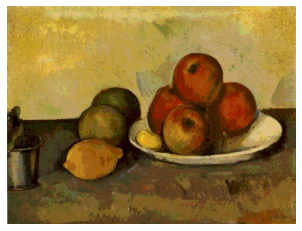

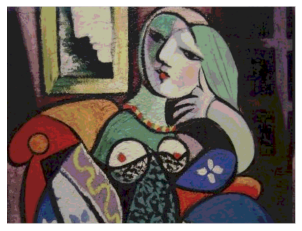

In [64]:
plt.imshow(restore(img_new1))
plt.axis("off")
plt.show()
plt.imshow(restore(img_new2))
plt.axis("off")
plt.show()

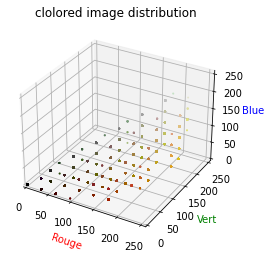

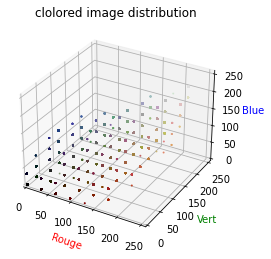

In [65]:
map(restore(img_new1))
map(restore(img_new2))

In [66]:
list1 = listC(img_new1)
list2 = listC(img_new2)
#print(list1)
#print(list2)

In [67]:
def couleur(img, r, g, b):
    n = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            (rouge,vert,bleu) = img[i,j] 
            if rouge == r and vert == g and bleu == b:
                n = n + 1
    return n

In [68]:
def count(image, list):
    list_mass = []
    for i in range(len(list)):
        (r, g, b) = list[i]
        list_mass.append(couleur(image, r, g, b))
    return list_mass

In [69]:
list_mass1 = count(img_new1, list1)
list_mass2 = count(img_new2, list2)
print(len(list1))
#print(len(list_mass1))
print(len(list2))
#print(len(list_mass2))

91
124


In [70]:
#Définir la distance entre deux couleurs
def distance(r1, g1, b1, r2, g2, b2):
    return pow((pow(int(r1) - int(r2), 2) + pow(int(g1) - int(g2), 2) + pow(int(b1) - int(b2), 2)), 0.5)

In [71]:
#print(list_mass1)
#print(list_mass2)

In [72]:
#Faire le transport optimal entre deux images
def transportOptimal_linprog(list1, list2, list_mass1, list_mass2):
    #Entrer le nombre de variables dans la fonction objectif
    n = len(list1) * len(list2)
    #Entrer les coefficients de la fonction objectif
    l = []
    for i in range(len(list2)):
        for j in range(len(list1)):
            (r1, g1, b1) = list2[i]
            (r2, g2, b2) = list1[j]
            l.append(distance(r1, g1, b1, r2, g2, b2))
    
    #Entrer la matrice des coefficients de contraintes
    s = (len(list1) + len(list2), len(list1) * len(list2))#la taille de la matrice des coefficients de contraintes
    a_eq = np.zeros(shape = s)
    
    for i in range(len(list2)):
        for j in range(len(list1)):
            a_eq[i][j + i * len(list1)] = 1
    for i in range(len(list1)):
        for j in range(len(list2)):
            a_eq[i + len(list2)][j * len(list1) + i] = 1

    #Entrer des valeurs de contraintes    
    b_eq = list_mass2 + list_mass1

    x_bounds = (0, None)
    bounds = []
    for i in range(n):
        bounds.append(x_bounds)
    
    result = linprog(l, A_eq=a_eq, b_eq=b_eq, bounds=bounds)
    print(result)
    return result.x
    


In [73]:
res = transportOptimal_linprog(list1, list2, list_mass1, list_mass2)

/var/folders/7l/gk8wp1sx1z7dwxf1nnv_nstw0000gn/T/ipykernel_52547/2910272896.py:32: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  result = linprog(l, A_eq=a_eq, b_eq=b_eq, bounds=bounds)


     con: array([ 1.81675181e-03,  5.71134873e-03,  2.12025039e-04,  2.57246933e-03,
        9.94852017e-03,  5.95820650e-03,  1.06014259e-05,  3.74072746e-04,
        9.34848672e-03,  5.94548426e-03,  5.36120452e-05,  1.79100585e-03,
        8.78389439e-05, -2.05967179e-05, -8.48100149e-06,  1.58110105e-03,
        4.72210061e-04,  4.69453790e-03,  4.31773805e-03,  8.45647058e-03,
        1.55626379e-03,  1.61775161e-03,  1.72739817e-03,  4.06724547e-03,
        5.59294730e-02,  2.17295370e-03,  1.33151727e-03,  3.43177658e-03,
        4.15750807e-03,  1.46660749e-03,  1.12221836e-03,  1.42662556e-03,
        3.40966597e-03,  1.32333913e-03,  2.20899802e-03,  5.11404399e-03,
        1.29941058e-04,  1.23035103e-03,  3.04680042e-03,  7.44510780e-04,
        1.36544122e-03,  1.36665270e-03,  4.37074468e-04,  4.17386441e-04,
        4.77359219e-04,  1.17825343e-04,  9.88339548e-04, -1.15099306e-05,
        5.32788636e-04,  6.14872608e-05,  7.29396513e-03,  3.90671358e-03,
        2.58822

In [74]:
def changeRes(res, a, b):
    res = res.reshape((a, b))
    res = res.T
    #print(res)
    x = 0
    y = 0
    for i in range(len(res)):
        for j in range(len(res[i])):
            if res[i][j] < 1 :
                x += res[i][j]
                res[i][j] = 0
            else:
                y = j
        res[i][y] += x
        x = 0
    return res

In [75]:
def cover(res, img, list1, list2):
    img1 = deepcopy(img)
    X = changeRes(res, len(list2), len(list1))
    for x in range(img1.shape[0]):
        for y in range(img1.shape[1]):
            (rouge,vert,bleu) = img1[x,y]
            i = list1.index((rouge,vert,bleu))
            for n in range(len(X[i])):
                if X[i][n] > 0:
                    img1[x,y] = list2[n]
                    X[i][n] -= 1
    #print(X)
    return img1
    

In [76]:
img_final = cover(res, img_new1, list1, list2)

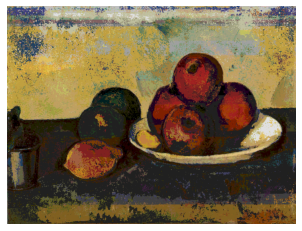

In [77]:
plt.imshow(restore(img_final))
plt.axis("off")
plt.show()

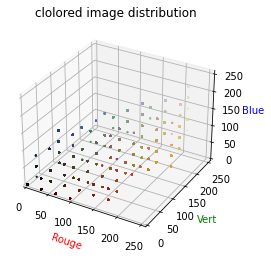

In [78]:
map(restore(img_final))